In [1]:
import pandas as pd
from glob import glob
import numpy as np
pd.set_option('display.max_rows', 300) 
data = "2009"

## Data exploration

In [2]:
vertices = pd.read_csv(f"../../preds{data}/strainselect/StrainSelect21_vertices.tab.txt",sep="\t")

/scratch/ipykernel_636121/1949464331.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  vertices = pd.read_csv(f"../../preds{data}/strainselect/StrainSelect21_vertices.tab.txt",sep="\t")


In [ ]:
vertices

,vertex,vertex_type,StrainSelectID,StrainSelectID_2019
0,103nt4.lake.natron,gss,t__595640,NaN
1,X92163,contig,t__595640,NaN
2,g16_0915863,g16,t__595640,NaN
3,105nt4.lake.natron,gss,t__575259,NaN
4,X92166,contig,t__575259,NaN
...,...,...,...,...
4002304,g16_0917076,g16,t__364615,NaN
4002305,leptospira.biflexa.mutant.2.1993,gss,t__364615,NaN
4002306,Z98593,contig,t__387752,NaN
4002307,g16_0917077,g16,t__387752,NaN


In [4]:
vertices.vertex_type.value_counts()

vertex_type
g16               884828
gss               878311
contig            720657
gb_assembly       275232
rs_assembly       259195
wgs_master_pre    245975
patric_genome     234506
gold_org          195479
si_culture_id     142317
brc_cat_id        117202
si_grouping_id     24298
biocyc_pgdb        17505
kegg_genome         6794
sg_assembly           10
Name: count, dtype: int64

In [5]:
df = pd.read_parquet(f"../../preds{data}/REL_output/preds_strainselect_grouped.pqt")

In [6]:
df.StrainSelectID.unique().shape

(57276,)

In [7]:
df.rel.value_counts()

rel
STRAIN-COMPOUND:PRODUCES          570899
STRAIN-MEDIUM:GROWS_ON            546784
STRAIN-PHENOTYPE:PRESENTS         417597
STRAIN-ISOLATE:INHABITS           331579
STRAIN-ORGANISM:INFECTS           209349
STRAIN-COMPOUND:RESISTS           186295
STRAIN-ORGANISM:INHABITS          153308
COMPOUND-STRAIN:INHIBITS          134377
STRAIN-DISEASE:ASSOCIATED_WITH     83039
STRAIN-COMPOUND:DEGRADES           81675
STRAIN-DISEASE:INHIBITS            81140
STRAIN-EFFECT:PROMOTES             66222
STRAIN-EFFECT:PRESENTS             50278
STRAIN-EFFECT:INHIBITS             32557
STRAIN-ORGANISM:SYMBIONT_OF        25358
STRAIN-ORGANISM:INHIBITS           24196
STRAIN-SPECIES:INHIBITS            18362
Name: count, dtype: int64

In [8]:
df.vertex_type.value_counts()

vertex_type
gss               722193
brc_cat_id         11377
contig              6754
biocyc_pgdb         1201
wgs_master_pre      1057
si_culture_id        967
g16                  581
si_grouping_id       112
Name: count, dtype: int64

In [9]:
set(vertices.vertex_type.value_counts().index).difference(set(df.vertex_type.value_counts().index))

{'gb_assembly',
 'gold_org',
 'kegg_genome',
 'patric_genome',
 'rs_assembly',
 'sg_assembly'}

In [10]:
res=["STRAIN-SPECIES:INHIBITS",    "STRAIN-ORGANISM:INHIBITS",
     "STRAIN-ORGANISM:SYMBIONT_OF","STRAIN-ORGANISM:INFECTS",
    "STRAIN-DISEASE:ASSOCIATED_WITH", "STRAIN-ORGANISM:INHABITS", "STRAIN-EFFECT:PROMOTES","STRAIN-EFFECT:INHIBITS"]

In [11]:
for re in res:
    df[df.rel==re].sort_values("word_qc").to_csv(f"network_files/{re}.csv")

<Axes: ylabel='Frequency'>

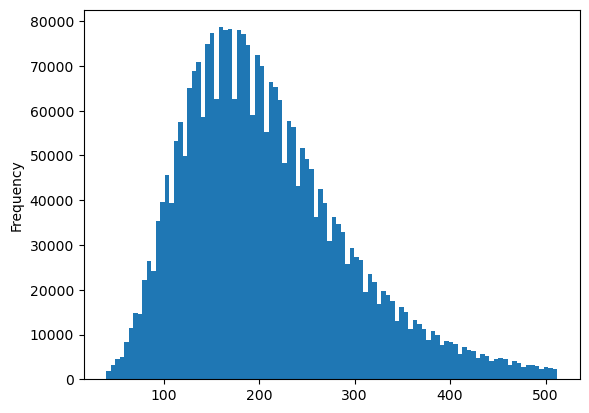

In [12]:
df.text.str.len().plot.hist(bins=100)

## Get sample sentences

In [13]:
df_nonan = df.dropna(subset = "StrainSelectID")

In [14]:
words = ["1","b","production","expression","p","c","a","uptake","resistance to","activity","salt","2","defense responses in", "growth of phytopathogenic bacterial"]
l = []
for i in words:
	l.append(df_nonan[df_nonan["word_qc"]==i].sample(1).text.to_list())

with open("network_files/rel_to_reannotate.txt","w") as f:
	for s in [i for j in l for i in j]:
		f.write(f"{s}\n")

In [16]:
words = ["l","1","2","s", "5","a","l.","v","coli","\("]
l = []
for i in words:
	l.append(df_nonan[df_nonan["word_strain_qc"].str.contains(i)].sample(4).text.to_list())

with open("network_files/rel_to_reannotate_strain.txt","w") as f:
	for s in [i for j in l for i in j]:
		f.write(f"{s}\n")